In [11]:
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline
from PIL import Image
import numpy as np

DATA_DIR = '/media/hdd10tb/zchen/dsb2018/data'
id_ = 'a5fe0b7412dd152c41f7afc34ffdf276d4261b6942fa6d36803648e90f2cfc06'
image = cv2.imread(DATA_DIR + '/zhen/stage1_train/images/%s.png'%(id_), cv2.IMREAD_COLOR)[:,:,:3]
image2 = Image.open(DATA_DIR + '/zhen/stage1_train/images/%s.png'%(id_), 'r')
image2 = image2.convert('RGB')

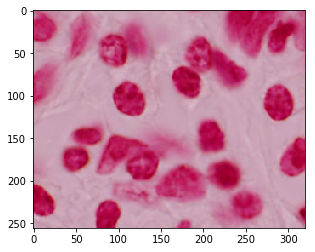

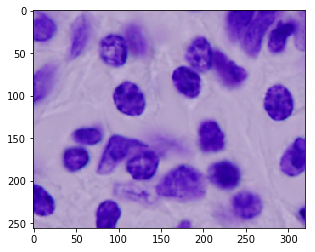

In [2]:
plt.imshow(image)
plt.show()
plt.imshow(image2)
plt.show()

In [2]:
import os, sys

from train_0 import *

##--------------------------------------------------------------


## overwrite functions ###
def revert(net, images):

    def torch_clip_proposals (proposals, index, width, height):
        boxes = torch.stack((
             proposals[index,0],
             proposals[index,1].clamp(0, width  - 1),
             proposals[index,2].clamp(0, height - 1),
             proposals[index,3].clamp(0, width  - 1),
             proposals[index,4].clamp(0, height - 1),
             proposals[index,5],
             proposals[index,6],
        ), 1)
        return proposals

    # ----

    batch_size = len(images)
    for b in range(batch_size):
        image  = images[b]
        height,width  = image.shape[:2]


        # net.rpn_logits_flat  <todo>
        # net.rpn_deltas_flat  <todo>
        # net.rpn_window       <todo>
        # net.rpn_proposals    <todo>

        # net.rcnn_logits
        # net.rcnn_deltas
        # net.rcnn_proposals <todo>

        # mask --
        # net.mask_logits
        index = (net.detections[:,0]==b).nonzero().view(-1)
        net.detections   = torch_clip_proposals (net.detections, index, width, height)

        net.masks[b] = net.masks[b][:height,:width]

    return net, image



def eval_augment(image, multi_mask, meta, index):

    pad_image = pad_to_factor(image, factor=16)
    input = torch.from_numpy(pad_image.transpose((2,0,1))).float().div(255)
    box, label, instance  = multi_mask_to_annotation(multi_mask)

    return input, box, label, instance, meta, image, index


def eval_collate(batch):

    batch_size = len(batch)
    #for b in range(batch_size): print (batch[b][0].size())
    inputs    = torch.stack([batch[b][0]for b in range(batch_size)], 0)
    boxes     =             [batch[b][1]for b in range(batch_size)]
    labels    =             [batch[b][2]for b in range(batch_size)]
    instances =             [batch[b][3]for b in range(batch_size)]
    metas     =             [batch[b][4]for b in range(batch_size)]
    images    =             [batch[b][5]for b in range(batch_size)]
    indices   =             [batch[b][6]for b in range(batch_size)]

    return [inputs, boxes, labels, instances, metas, images, indices]







/media/hdd10tb/zchen/dsb2018/code/newest/common.py:23: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zchen/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zchen/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zchen/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zchen/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance(

@common.py:  
	set random seed
		SEED=35202
	set cuda environment
		torch.__version__              = 0.4.0a0+cdd0feb
		torch.version.cuda             = 8.0.61
		torch.backends.cudnn.version() = 7005
		os['CUDA_VISIBLE_DEVICES']     = 3,2,1
		torch.cuda.device_count()      = 3
		torch.cuda.current_device()    = 0
DATA_DIR is  /media/hdd10tb/zchen/dsb2018/data
RESULTS_DIR is  /media/hdd10tb/zchen/dsb2018/results



In [3]:
out_dir  = RESULTS_DIR + '/config'
initial_checkpoint = \
    RESULTS_DIR + '/config/checkpoint/15020_model.pth'
    ##

## setup  ---------------------------
#     os.makedirs(out_dir +'/evaluate/overlays', exist_ok=True)
#     os.makedirs(out_dir +'/evaluate/npys', exist_ok=True)
#     os.makedirs(out_dir +'/checkpoint', exist_ok=True)
#     os.makedirs(out_dir +'/backup', exist_ok=True)
#     backup_project_as_zip(PROJECT_PATH, out_dir +'/backup/code.%s.zip'%IDENTIFIER)

log = Logger()
log.open(out_dir+'/log.evaluate.txt',mode='a')
log.write('\n--- [START %s] %s\n\n' % (IDENTIFIER, '-' * 64))
log.write('** some experiment setting **\n')
log.write('\tSEED         = %u\n' % SEED)
log.write('\tPROJECT_PATH = %s\n' % PROJECT_PATH)
log.write('\tout_dir      = %s\n' % out_dir)
log.write('\n')


## net ------------------------------
cfg = Configuration()
# cfg.rpn_train_nms_pre_score_threshold = 0.8 #0.885#0.5
# cfg.rpn_test_nms_pre_score_threshold  = 0.8 #0.885#0.5

net = MaskRcnnNet(cfg).cuda()
if initial_checkpoint is not None:
    log.write('\tinitial_checkpoint = %s\n' % initial_checkpoint)
    net.load_state_dict(torch.load(initial_checkpoint, map_location=lambda storage, loc: storage))


log.write('%s\n\n'%(type(net)))
log.write('\n')



## dataset ----------------------------------------
log.write('** dataset setting **\n')

test_dataset = ScienceDataset(
                            #'train1_ids_gray2_500', mode='train',
                            'valid_ids_66', mode='train',
                            #'debug1_ids_gray2_10', mode='train',
                            transform = eval_augment)
test_loader  = DataLoader(
                    test_dataset,
                    sampler = SequentialSampler(test_dataset),
                    batch_size  = 1,
                    drop_last   = False,
                    num_workers = 4,
                    pin_memory  = True,
                    collate_fn  = eval_collate)


log.write('\ttest_dataset.split = %s\n'%(test_dataset.split))
log.write('\tlen(test_dataset)  = %d\n'%(len(test_dataset)))
log.write('\n')


--- [START 2018-03-21_16-13-46] ----------------------------------------------------------------

** some experiment setting **
	SEED         = 35202
	PROJECT_PATH = /media/hdd10tb/zchen/dsb2018/code/newest
	out_dir      = /media/hdd10tb/zchen/dsb2018/results/config

	initial_checkpoint = /media/hdd10tb/zchen/dsb2018/results/config/checkpoint/15020_model.pth
<class 'net.resnet50_mask_rcnn.model.MaskRcnnNet'>


** dataset setting **
	time = 0.00 min
	num_ids = 66

	test_dataset.split = valid_ids_66
	len(test_dataset)  = 66



In [4]:
l = []
for inputs, truth_boxes, truth_labels, truth_instances, metas, images, indices in test_loader:
    l.append((inputs, truth_boxes, truth_labels, truth_instances, metas, images, indices))

In [5]:
log.write('** start evaluation here! **\n')
mask_average_precisions = []
box_precisions_50  = []

test_num  = 0
test_loss = np.zeros(5,np.float32)
test_acc  = 0

** start evaluation here! **


In [6]:
def draw_multi_proposal_metric(cfg, image, proposal, truth_box, truth_label,
                          color0=[0,255,255], color1=[255,0,255], color2=[255,255,0],thickness=1):

    H,W = image.shape[:2]
    image_truth    = image.copy()  #yellow
    image_proposal = image.copy()  #pink
    image_hit      = image.copy()  #cyan
    image_miss     = image.copy()  #yellow
    image_fp       = image.copy()  #pink
    image_invalid  = image.copy()  #white
    precision = 0

    if len(proposal)>0 and len(truth_box)>0:

        thresholds=[0.5,]

        box = proposal[:,1:5]
        precisions, recalls, results, truth_results = \
            compute_precision_for_box(box, truth_box, truth_label, thresholds)

        #for precision, recall, result, truth_result, threshold in zip(precisions, recalls, results, truth_results, thresholds):

        if 1:
            precision, recall, result, truth_result, threshold = \
                precisions[0], recalls[0], results[0], truth_results[0], thresholds[0]


            for i,b in enumerate(truth_box):
                x0,y0,x1,y1 = b.astype(np.int32)

                if truth_result[i]==HIT:
                    cv2.rectangle(image_truth,(x0,y0), (x1,y1), color0, thickness)
                    draw_screen_rect(image_hit,(x0,y0), (x1,y1), color2, 0.25)

                if truth_result[i]==MISS:
                    cv2.rectangle(image_truth,(x0,y0), (x1,y1), color0, thickness)
                    cv2.rectangle(image_miss,(x0,y0), (x1,y1), color0, thickness)

                if truth_result[i]==INVALID:
                    draw_screen_rect(image_invalid,(x0,y0), (x1,y1), (255,255,255), 0.5)

            for i,b in enumerate(box):
                x0,y0,x1,y1 = b.astype(np.int32)
                cv2.rectangle(image_proposal,(x0,y0), (x1,y1), color1, thickness)

                if result[i]==TP:
                    cv2.rectangle(image_hit,(x0,y0), (x1,y1), color2, thickness)

                if result[i]==FP:
                    cv2.rectangle(image_fp,(x0,y0), (x1,y1), color1, thickness) #255,0,255

                if result[i]==INVALID:
                    cv2.rectangle(image_invalid,(x0,y0), (x1,y1), (255,255,255), thickness)

    draw_shadow_text(image_truth, 'truth',  (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(image_proposal,'proposal', (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(image_hit, 'hit',  (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(image_miss,'miss', (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(image_fp,  'fp',   (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(image_invalid, 'n.a.', (5,15),0.5, (255,255,255), 1)
    
    all = [image_truth,image_proposal,image_hit,image_miss,image_fp,image_invalid]
    # draw_shadow_text(all,'%0.2f prec@0.5'%precision, (5,H-15),0.5, (255,255,255), 1)
    return all

In [7]:
def draw_mask_metric(cfg, image, mask, truth_box, truth_label, truth_instance):

    H,W = image.shape[:2]
    overlay_truth   = np.zeros((H,W,3),np.uint8)  #yellow
    overlay_mask    = np.zeros((H,W,3),np.uint8)  #pink
    overlay_error   = np.zeros((H,W,3),np.uint8)
    overlay_metric  = np.zeros((H,W,3),np.uint8)
    overlay_contour = image.copy()
    average_overlap   = 0
    average_precision = 0
    precision_50 = 0
    precision_70 = 0

    if len(truth_box)>0:

        #pixel error: fp and miss
        truth_mask = instance_to_multi_mask(truth_instance)
        truth      = truth_mask!=0

        predict = mask!=0
        hit  = truth & predict
        miss = truth & (~predict)
        fp   = (~truth) & predict

        overlay_error[hit ]=[128,128,0]
        overlay_error[fp  ]=[255,0,255]
        overlay_error[miss]=[0,255,255]

        # truth and mask ---
        overlay_mask [predict]=[64,0,64]
        overlay_truth[truth  ]=[0,64,64]
        overlay_mask  = multi_mask_to_contour_overlay(mask,overlay_mask,[255,0,255])
        overlay_truth = multi_mask_to_contour_overlay(truth_mask,overlay_truth,[0,255,255])

        overlay_contour = multi_mask_to_contour_overlay(mask,overlay_contour,[255,0,255])

        # metric -----
        predict = mask
        truth   = instance_to_multi_mask(truth_instance)

        num_truth   = len(np.unique(truth  ))-1
        num_predict = len(np.unique(predict))-1

        if num_predict!=0:
            intersection = np.histogram2d(truth.flatten(), predict.flatten(), bins=(num_truth+1, num_predict+1))[0]

            # Compute areas (needed for finding the union between all objects)
            area_true = np.histogram(truth,   bins = num_truth  +1)[0]
            area_pred = np.histogram(predict, bins = num_predict+1)[0]
            area_true = np.expand_dims(area_true, -1)
            area_pred = np.expand_dims(area_pred,  0)
            union = area_true + area_pred - intersection
            intersection = intersection[1:,1:]   # Exclude background from the analysis
            union = union[1:,1:]
            union[union == 0] = 1e-9
            iou = intersection / union # Compute the intersection over union

            precision = {}
            average_precision = 0
            thresholds = np.arange(0.5, 1.0, 0.05)
            for t in thresholds:
                tp, fp, fn = compute_precision(t, iou)
                prec = tp / (tp + fp + fn)
                precision[round(t,2) ]=prec
                average_precision += prec
            average_precision /= len(thresholds)
            precision_50 = precision[0.50]
            precision_70 = precision[0.70]


            #iou = num_truth, num_predict
            overlap = np.max(iou,1)
            assign  = np.argmax(iou,1)
            #print(overlap)

            for t in range(num_truth):
                s = overlap[t]
                if s>0.5:
                    color = to_color(max(0.0,(overlap[t]-0.5)/0.5), [255,255,255])
                else:
                    color = [0,0,255] #to_color(max(0.0,(0.5-overlap[t])/0.5), [0,255,0])
                overlay_metric[truth_instance[t]>0]=color

            overlay_metric = multi_mask_to_contour_overlay(mask,overlay_metric,[255,0,255])
            average_overlap = overlap.mean()

    draw_shadow_text(overlay_truth,   'truth',  (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(overlay_mask,    'mask',   (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(overlay_error,   'error',  (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(overlay_metric,  '%0.2f iou '%average_overlap,    (5,15),0.5, (255,255,255), 1)
    draw_shadow_text(overlay_contour, 'contour', (5,15),0.5, (255,255,255), 1)
    
    # all = [overlay_truth, overlay_mask, overlay_error, overlay_metric, overlay_contour]
    all = [overlay_truth, overlay_mask, overlay_error, overlay_metric], average_overlap
    # all = [overlay_truth, overlay_mask, overlay_error]
    # draw_shadow_text(all,'%0.2f prec@0.5'%(precision_50), (5,H-45),0.5, (255,255,255), 1)
    # draw_shadow_text(all,'%0.2f prec@0.7'%(precision_70), (5,H-30),0.5, (255,255,255), 1)
    # draw_shadow_text(all,'%0.2f prec'%average_precision,  (5,H-15),0.5, (255,255,0), 1)
    #image_show('all mask : image, truth, predict, error, metric',all,1)

    return all

In [8]:
def average_iou_meric(cfg, image, mask, truth_box, truth_label, truth_instance):

    H,W = image.shape[:2]
    average_overlap   = 0
    average_precision = 0

    if len(truth_box)>0:

        #pixel error: fp and miss
        truth_mask = instance_to_multi_mask(truth_instance)
        truth      = truth_mask!=0

        predict = mask!=0
        hit  = truth & predict
        miss = truth & (~predict)
        fp   = (~truth) & predict

        # metric -----
        predict = mask
        truth   = instance_to_multi_mask(truth_instance)

        num_truth   = len(np.unique(truth  ))-1
        num_predict = len(np.unique(predict))-1

        if num_predict!=0:
            intersection = np.histogram2d(truth.flatten(), predict.flatten(), bins=(num_truth+1, num_predict+1))[0]

            # Compute areas (needed for finding the union between all objects)
            area_true = np.histogram(truth,   bins = num_truth  +1)[0]
            area_pred = np.histogram(predict, bins = num_predict+1)[0]
            area_true = np.expand_dims(area_true, -1)
            area_pred = np.expand_dims(area_pred,  0)
            union = area_true + area_pred - intersection
            intersection = intersection[1:,1:]   # Exclude background from the analysis
            union = union[1:,1:]
            union[union == 0] = 1e-9
            iou = intersection / union # Compute the intersection over union

            precision = {}
            average_precision = 0
            thresholds = np.arange(0.5, 1.0, 0.05)
            for t in thresholds:
                tp, fp, fn = compute_precision(t, iou)
                prec = tp / (tp + fp + fn)
                precision[round(t,2) ]=prec
                average_precision += prec
            average_precision /= len(thresholds)


            #iou = num_truth, num_predict
            overlap = np.max(iou,1)

            average_overlap = overlap.mean()

    return average_overlap

In [65]:
# 0 1 small box, mask shape
# 3 22 24 29 46 55 57 58 shape
# 4 21 ?
# 2 5 6 15 25color 30 35 44 50 53 59 61 62 63 miss, shape
# 7 8 17 26 27 28 34 36 42 51 52 54 56 good 
# 9 miss, anchor box shape?
# 10 11 12 13 33color 37 43 45 48 64color 65 miss
##### 14 color
# 16 21 39 many small ones regard as one big 
# 18 miss two big one and small one
##### 19 40 miss a lot 
# 23 color
# 31 47 small 
# 41 49 60 nms



# 32 38
# ? 27 truth is not right

In [14]:
i = 2
inputs, truth_boxes, truth_labels, truth_instances, metas, images, indices = l[i]
net.set_mode('test')
with torch.no_grad():
    inputs = Variable(inputs).cuda()
    net(inputs, truth_boxes,  truth_labels, truth_instances )


##save results ---------------------------------------
revert(net, images)


batch_size = len(indices)
assert(batch_size==1)  #note current version support batch_size==1 for variable size input
                       #to use batch_size>1, need to fix code for net.windows, etc

batch_size,C,H,W = inputs.size()
inputs = inputs.data.cpu().numpy()

masks      = net.masks
detections = net.detections.cpu().numpy()


for b in range(batch_size):
    image  = images[b]
    height,width  = image.shape[:2]
    mask = masks[b]

    index = np.where(detections[:,0]==b)[0]
    detection = detections[index]
    box = detection[:,1:5]


    truth_mask = instance_to_multi_mask(truth_instances[b])
    truth_box  = truth_boxes[b]
    truth_label= truth_labels[b]
    truth_instance= truth_instances[b]


    mask_average_precision, mask_precision =\
        compute_average_precision_for_mask(mask, truth_mask, t_range=np.arange(0.5, 1.0, 0.05))

    box_precision, box_recall, box_result, truth_box_result = \
        compute_precision_for_box(box, truth_box, truth_label, threshold=[0.5])
    box_precision = box_precision[0]

    mask_average_precisions.append(mask_average_precision)
    box_precisions_50.append(box_precision)


    # --------------------------------------------
    all6 = draw_multi_proposal_metric(cfg, image, detection, truth_box, truth_label,[0,255,255],[255,0,255],[255,255,0])
    all7,iou = draw_mask_metric(cfg, image, mask, truth_box, truth_label, truth_instance)
    id_ = test_dataset.ids[indices[b]]
    
    print('%s\t%0.5f %0.5f  (%0.5f)'%(id_,iou,mask_average_precision, box_precision))



a7a581e6760df4701941670e73d72533e3b0fbd7563488ad92772b41f7709710	0.88231 0.75317  (0.85211)


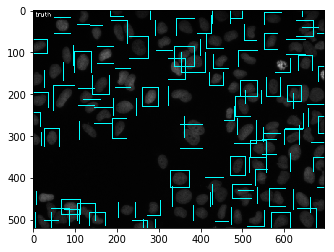

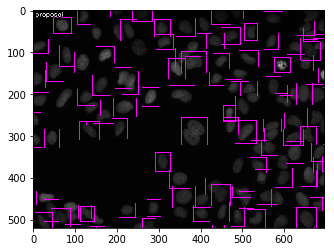

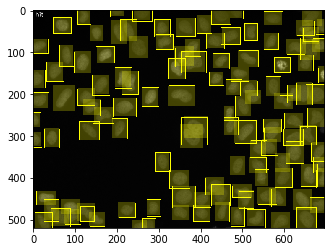

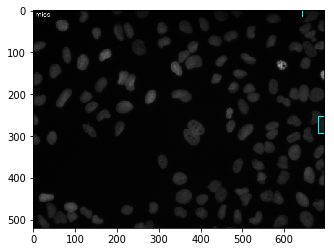

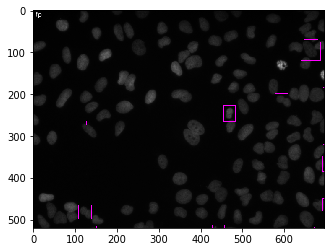

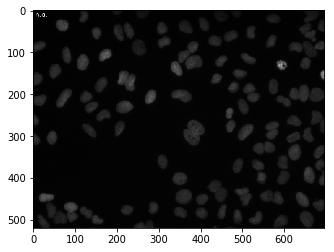

In [15]:
for img in all6:
    plt.imshow(img)
    plt.show()

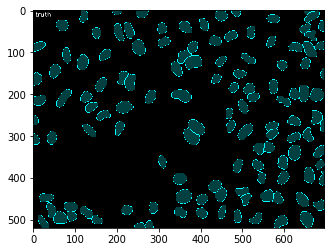

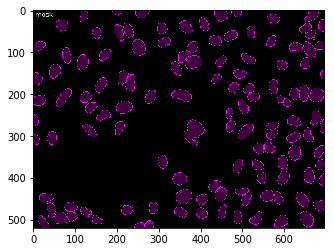

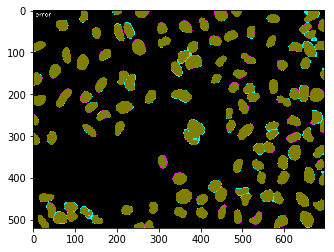

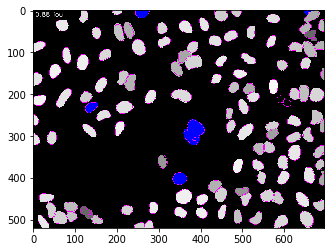

In [11]:
for img in all7:
    plt.imshow(img)
    plt.show()

In [3]:
def scale_image_canals(image):
    for i in range(image.shape[2]):
        canal = image[:,:,i]
        canal = canal - canal.min()
        canalmax = canal.max()
        if canalmax > 0:
            factor = 255/canalmax
            canal = (canal * factor).astype(int)
        image[:,:,i] = canal
    return image

In [37]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np

DATA_DIR = '/media/hdd10tb/zchen/dsb2018/data'
target = Image.open(DATA_DIR + '/zhen/stage1_train/images/%s.png'%(t[0]), 'r')
target = target.convert('RGB')
target = np.array(target)
image2 = Image.open(DATA_DIR + '/zhen/stage1_train/images/%s.png'%(t[10]), 'r')
image2 = image2.convert('RGB')
image2 = np.array(image2)

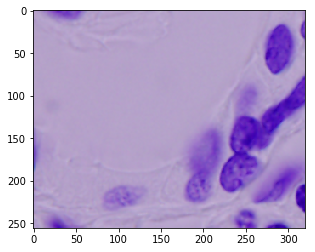

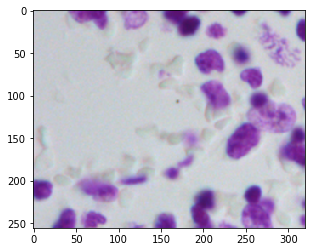

In [38]:
plt.imshow(target)
plt.show()
plt.imshow(image2)
plt.show()

In [2]:
import csv
fluorescent_ids = []
with open('/media/hdd10tb/zchen/dsb2018/data/three classes/fluorescent.csv', 'r') as f:
    r = csv.reader(f)
    for row in r:
        fluorescent_ids.append(row[1])
        
bright_field_ids = []
with open('/media/hdd10tb/zchen/dsb2018/data/three classes/bright_field.csv', 'r') as f:
    r = csv.reader(f)
    for row in r:
        bright_field_ids.append(row[1])
        
histological_ids = []
with open('/media/hdd10tb/zchen/dsb2018/data/three classes/histological.csv', 'r') as f:
    r = csv.reader(f)
    for row in r:
        histological_ids.append(row[1]) 

In [7]:
fluorescent_test_ids = []
with open('/media/hdd10tb/zchen/dsb2018/data/three classes/fluorescent_test.csv', 'r') as f:
    r = csv.reader(f)
    for row in r:
        fluorescent_test_ids.append(row[0])
        
bright_field_test_ids = []
with open('/media/hdd10tb/zchen/dsb2018/data/three classes/bright_field_test.csv', 'r') as f:
    r = csv.reader(f)
    for row in r:
        bright_field_test_ids.append(row[0])
        
histological_test_ids = []
with open('/media/hdd10tb/zchen/dsb2018/data/three classes/histological_test.csv', 'r') as f:
    r = csv.reader(f)
    for row in r:
        histological_test_ids.append(row[0]) 

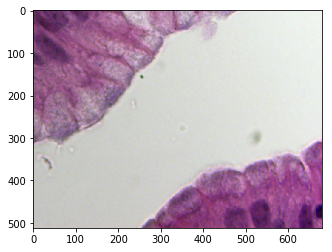

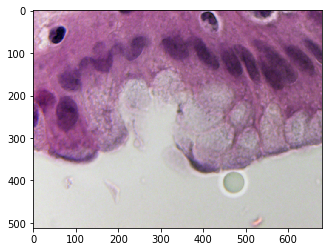

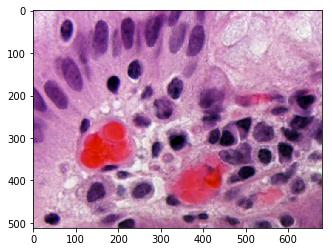

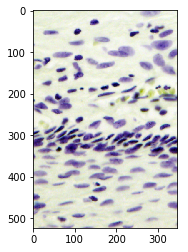

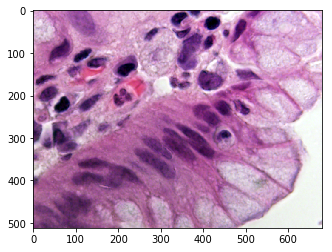

In [15]:
for id_ in histological_test_ids:
    img = Image.open(DATA_DIR + '/zhen/stage1_test/images/%s.png'%(id_), 'r')
    img = img.convert('RGB')
    img = np.array(img)
    plt.imshow(img)
    plt.show()

In [16]:
gray_ids = fluorescent_ids + bright_field_ids
color_ids = histological_ids
test_gray_ids = fluorescent_test_ids
test_color_ids = bright_field_test_ids + histological_test_ids

In [19]:
test_gray_name = 'test_ids_gray_53'
test_color_name = 'test_ids_color_12'
# test_name = 'test_ids_65'

with open('/media/hdd10tb/zchen/dsb2018/data/split/'+test_gray_name, 'w') as fp:
    fp.write('\n'.join(test_gray_ids))
    
with open('/media/hdd10tb/zchen/dsb2018/data/split/'+test_color_name, 'w') as fp:
    fp.write('\n'.join(test_color_ids))

In [3]:
from random import shuffle
shuffle(gray_ids)
shuffle(color_ids)

In [4]:
len(color_ids)

108

In [16]:
train_ids_gray_506 = gray_ids[0:506]
valid_ids_gray_56 = gray_ids[506:]
train_ids_color_98 = color_ids[0:98]
valid_ids_color_10 = color_ids[98:]
print(len(train_ids_color_98))
print(len(valid_ids_color_10))

98
10


In [17]:
print(train_ids_color_98[-1])
print(valid_ids_color_10[0])

2255d5aba044256bb92f6b7cbed0fca46d972c7b6b1a59dcbe7f682c5777d074
92f31f591929a30e4309ab75185c96ff4314ce0a7ead2ed2c2171897ad1da0c7


In [26]:
train_name = 'train_ids_color_98'
valid_name = 'valid_ids_color_10'
# test_name = 'test_ids_65'

with open('/media/hdd10tb/zchen/dsb2018/data/split/'+train_name, 'w') as fp:
    fp.write('\n'.join(train_ids_color_98))
    
with open('/media/hdd10tb/zchen/dsb2018/data/split/'+valid_name, 'w') as fp:
    fp.write('\n'.join(valid_ids_color_10))

In [1]:
def read_list_from_file(list_file, comment='#', func=None):
    with open(list_file) as f:
        lines  = f.readlines()

    strings=[]
    for line in lines:
        s = line.split(comment, 1)[0].strip()
        if s != '':
            strings.append(s)
    if func is not None:
        strings=[func(s) for s in strings]

    return strings

In [2]:
train_name = 'train_ids_fix_598'
valid_name = 'valid_ids_color_10'
t = read_list_from_file('/media/hdd10tb/zchen/dsb2018/data/split/'+train_name)
v = read_list_from_file('/media/hdd10tb/zchen/dsb2018/data/split/'+valid_name)

In [3]:
len(t)

598

In [13]:
count = 0
for id_ in fluorescent_ids:
    if id_ in t:
        count += 1
        

In [26]:
from StainNormalization import stainNorm_Macenko
from StainNormalization import stainNorm_Reinhard
from StainNormalization import stainNorm_Vahadane

In [10]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import numpy as np
import scipy.misc


DATA_DIR = '/media/hdd10tb/zchen/dsb2018/data'
target = Image.open(DATA_DIR + '/zhen/stage1_train/images/%s.png'%(v[0]), 'r')
target = target.convert('RGB')
target = np.array(target)

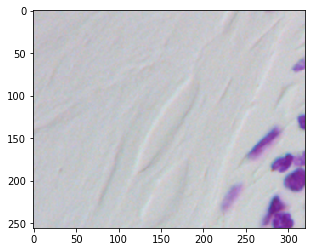

In [11]:
plt.imshow(target)
plt.show()

In [29]:
t = read_list_from_file('/media/hdd10tb/zchen/dsb2018/data/split/test_ids_color_12')

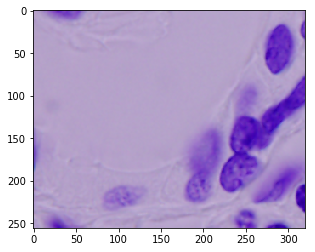

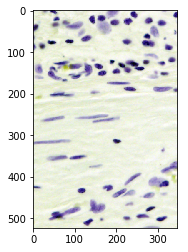

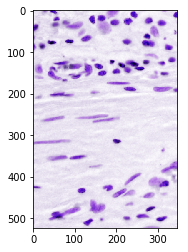

In [31]:
image2 = Image.open(DATA_DIR + '/zhen/stage1_test/images/%s.png'%(t[0]), 'r')
image2 = image2.convert('RGB')
image2 = np.array(image2)
plt.imshow(target)
plt.show()
plt.imshow(image2)
plt.show()
n = stainNorm_Vahadane.normalizer()
n.fit(target)
plt.imshow(n.transform(image2))
plt.show()

/home/zchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


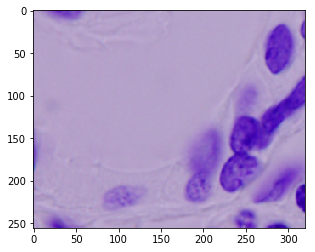

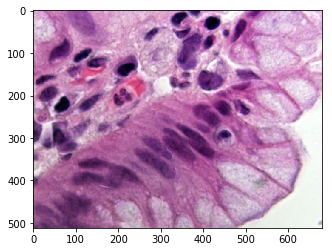

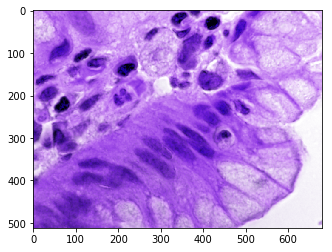

In [33]:
n = stainNorm_Vahadane.normalizer()
n.fit(target)
for id_ in t:
    image2 = Image.open(DATA_DIR + '/zhen/stage1_test/images/%s.png'%(id_), 'r')
    image2 = image2.convert('RGB')
    image2 = np.array(image2)
    image3 = n.transform(image2)
    scipy.misc.imsave('/media/hdd10tb/zchen/dsb2018/data/color_norm/'+id_+'.png', image3)
plt.imshow(target)
plt.show()
plt.imshow(image2)
plt.show()
plt.imshow(image3)
plt.show()

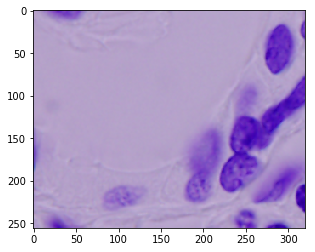

(1, 256, 320, 3)


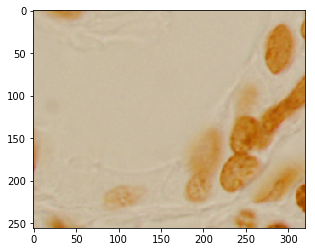

In [57]:
from augmentation import color_seq
plt.imshow(target)
plt.show()
target2 = np.expand_dims(target, axis=0)
target2 = color_seq.augment_images(target2)
print(target2.shape)
plt.imshow(np.squeeze(target2))
plt.show()

In [41]:
import csv
import torch
w = []
with open('/media/hdd10tb/zchen/dsb2018/results/config/weights.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
        w.append(float(row[1][1:-1]))

In [42]:
w1 = torch.tensor(w)
w1 = 1 / w1
w1 = w1 / sum(w1)

In [45]:
type(w1)

torch.autograd.variable.Variable

In [7]:
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
from random import randint
import cv2

In [36]:
ROOT_DIR ='/media/hdd10tb/zchen/dsb2018'
DATA_DIR    = ROOT_DIR + '/data'
i = 40
id_ = t[i]
image = cv2.imread(DATA_DIR + '/zhen_fix/stage1_train/images/%s.png'%(id_), cv2.IMREAD_COLOR)
image = np.array(image)
multi_mask = np.load( DATA_DIR + '/zhen_fix/stage1_train/multi_masks/%s.npy'%(id_)).astype(np.int32)

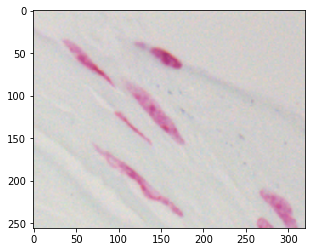

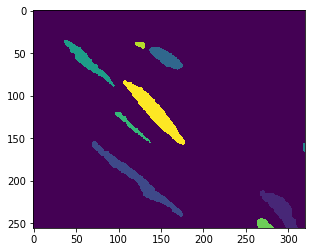

In [37]:
plt.imshow(image)
plt.show()
plt.imshow(multi_mask)
plt.show()
image, multi_mask = elastic_transform(image, multi_mask)
plt.imshow(image)
plt.show()
plt.imshow(multi_mask)
plt.show()

In [33]:
def elastic_transform(image, mask, sigma=12, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_.
        .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
           Convolutional Neural Networks applied to Visual Document Analysis", in
           Proc. of the International Conference on Document Analysis and
           Recognition, 2003.
        """
    # assert len(image.shape)==2
    
    alpha = randint(100, 200)
    if random_state is None:
            random_state = np.random.RandomState(None)
    
    shape = image.shape[0:2]
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    if len(image.shape) > 2:
        for c in range(image.shape[2]):
            image[:,:,c] = map_coordinates(image[:,:,c], indices, order=1).reshape(shape)
    else:
        image = map_coordinates(image, indices, order=1).reshape(shape)
    mask = map_coordinates(mask, indices, order=1).reshape(shape)
    return image, mask

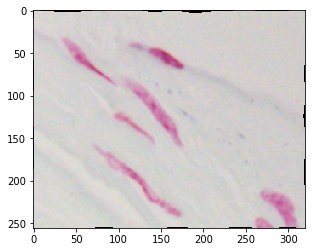

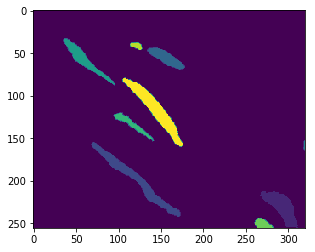